In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import joblib
import random

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

# ACF/PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from itertools import product 
from tqdm import tqdm_notebook

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data:
Source: https://www.datacamp.com/courses/forecasting-using-arima-models-in-python

In [3]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)
candy.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


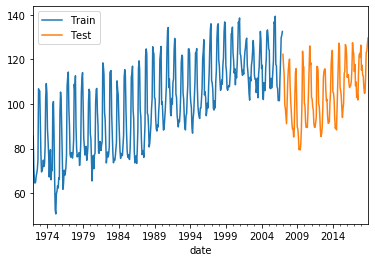

In [4]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test setsa dn show
candy_train.plot(ax=ax)
candy_test.plot(ax=ax)
ax.legend(["Train", "Test"]);
plt.show()

## Seasonality

Find seasonal period by looking at consecutive maxima in ACF

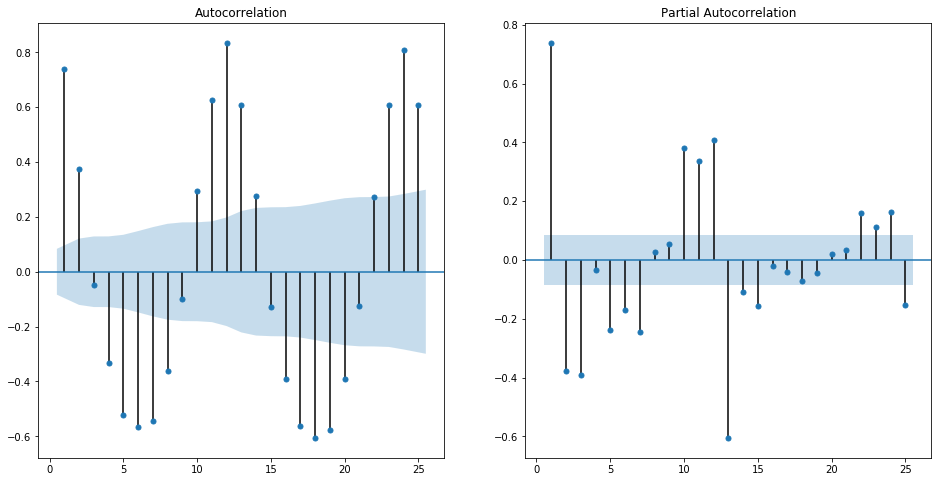

In [5]:
# Subtract the rolling mean
candy2 = candy - candy.rolling(15).mean()

# Drop the NaN values
candy2 = candy2.dropna()

# Create figure and subplots
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(16,8))

# Plot the ACF
plot_acf(candy2['IPG3113N'], lags=25, zero=False, ax=ax1)
plot_pacf(candy2['IPG3113N'], lags=25, zero=False, ax=ax2)

# Show figure
plt.show()

### Hyperparameter optimization

Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [6]:
# setting initial values and some bounds for them
ps = range(0, 2)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=0 
Qs = range(0, 3)
s = 12

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list), parameters_list[2])

36 (0, 0, 0, 2)


In [7]:
def optimizeSARIMA(series, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results_all = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = SARIMAX(series, 
                            order=(param[0], d, param[1]), 
                            seasonal_order=(param[2], D, param[3], s))
            result = model.fit(disp=-1)
        except:
            print('Parameters not working')
            continue
        aic = result.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = result
            best_aic = aic
            best_param = param
            
        print(f"Parameters: {param}")
        print(f"AIC:        {aic}")
        
        results_all.append([param, aic])

    result_table = pd.DataFrame(results_all)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [8]:
%%time
result_table = optimizeSARIMA(candy['IPG3113N'], parameters_list, d, D, s)

Parameters: (0, 0, 0, 0)
AIC:        4066.059621109613
Parameters: (0, 0, 0, 1)
AIC:        3718.47583026304
Parameters: (0, 0, 0, 2)
AIC:        3557.8040771841943
Parameters: (0, 0, 1, 0)
AIC:        3316.1679878108653
Parameters: (0, 0, 1, 1)
AIC:        3185.4431998580885
Parameters: (0, 0, 1, 2)
AIC:        3176.455544973851
Parameters: (0, 1, 0, 0)
AIC:        4039.3290617466964
Parameters: (0, 1, 0, 1)
AIC:        3714.781135729865
Parameters: (0, 1, 0, 2)
AIC:        3556.9250584388847
Parameters: (0, 1, 1, 0)
AIC:        3290.5887845499583
Parameters: (0, 1, 1, 1)
AIC:        3144.995266969951
Parameters: (0, 1, 1, 2)
AIC:        3140.198801602974
Parameters: (0, 2, 0, 0)
AIC:        3991.66195423242
Parameters: (0, 2, 0, 1)
AIC:        3699.344880212605
Parameters: (0, 2, 0, 2)
AIC:        3557.895010371281
Parameters: (0, 2, 1, 0)
AIC:        3284.3528291605744
Parameters: (0, 2, 1, 1)
AIC:        3135.9028720326132
Parameters: (0, 2, 1, 2)
AIC:        3129.986483840996
Para

In [9]:
result_table.head()

,parameters,aic
0,"(1, 2, 1, 2)",3120.809244
1,"(1, 1, 1, 2)",3123.777240
2,"(1, 2, 1, 1)",3127.092261
3,"(0, 2, 1, 2)",3129.986484
4,"(1, 1, 1, 1)",3131.435923


### Best model diagnostics

Diagnostics on residuals `y_true - y_pred` can give us several insights about our fits. Residuals should:
 - be uncorrelated (otherwise it means there is more information in the data).
 - have zero mean (or else it could indicate biases)
 - have constant variance.
 - be normally distributed.
 
Source: [Forecasting: Principles and Practice](https://otexts.com/fpp2/residuals.html)

In [10]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=SARIMAX(candy['IPG3113N'], 
                   order=(p, d, q), 
                   seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           IPG3113N   No. Observations:                  564
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1553.405
Date:                            Sun, 01 Sep 2019   AIC                           3120.809
Time:                                    12:11:33   BIC                           3151.142
Sample:                                01-01-1972   HQIC                          3132.651
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8418      0.042     20.182      0.000       0.760       0.924
ma.L1         -1.1531      0.065   

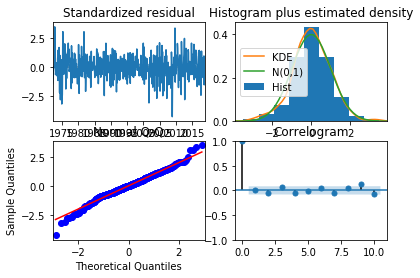

In [11]:
best_model.plot_diagnostics()
plt.show()

**Interpretation**: The fit appears to be great because the residuals seem to have a zero mean, no significant ACF at lags > 0, they do not seem to have significant outliers (quantiles), and they seem to follow a Gaussian distribution (histogram).

## Forecasting

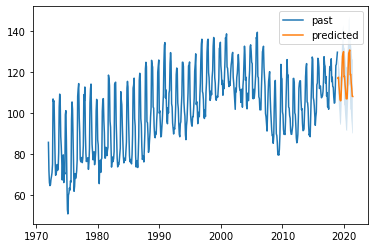

In [12]:
#model = SARIMAX(candy, order=(1,1,2), seasonal_order=(1,0,2,12))
#results = model.fit()

# Create forecast object
forecast_object = best_model.get_forecast(30)

# Extract prediction mean
mean = forecast_object.predicted_mean

# Extract the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

plt.figure()

# Plot past CO2 levels
plt.plot(candy.index.values, candy.values, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.legend()